# Figure 4 - Ye et al. 2023

- import dependencies
- note, this requires `cebra`

In [1]:
import cebra.integrations.matplotlib as cebra_plot
import joblib
import json
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from ruamel.yaml import YAML
from scipy import signal
from sklearn.decomposition import FastICA

sns.set_style('ticks')

# Display box plots of (un)supported rearing F1 scores 

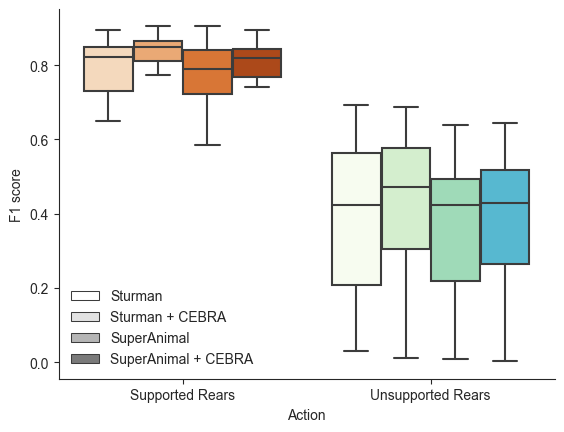

In [33]:
def plot_figure3d():
    df = pd.read_csv('../data/Figure4/rears.csv', sep=';', header=[0], index_col=0)
    box = sns.boxplot(data=df, x="action", y="f1", hue="method", palette='Oranges', flierprops=dict(markersize=0), hue_order=['Sturman', 'Sturman + CEBRA', 'SuperAnimal', 'SuperAnimal + CEBRA'])
    colors = plt.cm.get_cmap('GnBu', 6)(range(4))
    for patch, color in zip(box.patches[-4:], colors):
        patch.set_facecolor(color)
    sns.despine()
    leg = plt.legend(loc='lower left', frameon=False)
    colors = plt.cm.get_cmap('Greys', 6)(range(4))
    for patch, color in zip(leg.get_patches(), colors):
        patch.set_facecolor(color)
    plt.xlabel('Action')
    plt.ylabel('F1 score')

plot_figure3d()

# Visualize SuperAnimal and Sturman latent spaces with CEBRA

/Users/jessy/miniconda/envs/dlc/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/jessy/miniconda/envs/dlc/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


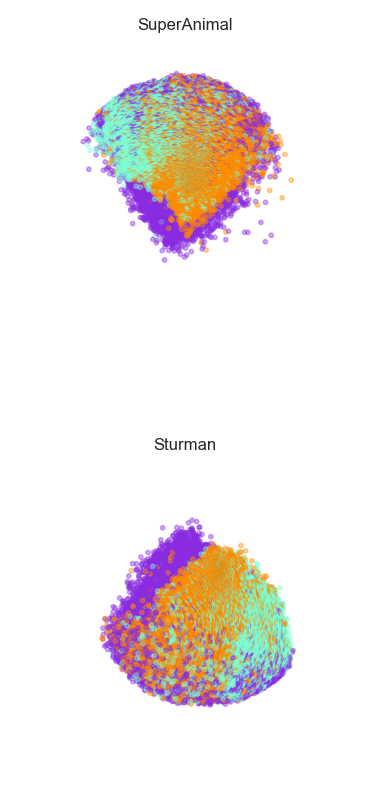

In [27]:
def plot_figure3e():
    cmap = ListedColormap(['blueviolet', 'darkorange', 'aquamarine'])  # other, supported, unsupported
    pca = FastICA(n_components=3, fun='exp')

    emb_train_sa, y_train_sa, *_ = joblib.load('../data/Figure4/emb_sa.pth')
    emb_train_sa = pca.fit_transform(emb_train_sa)
    emb_train_sturman, y_train_sturman, *_ = joblib.load('../data/Figure4/emb_sturman.pth')
    emb_train_sturman = pca.fit_transform(emb_train_sturman)

    fig = plt.figure(figsize=(5, 10))

    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    ax1.view_init(elev=31, azim=-13)
    ax1.axis('off')
    cebra_plot.plot_embedding(
        emb_train_sa, y_train_sa, cmap=cmap,
        ax=ax1, alpha=.4, markersize=10,
        title='SuperAnimal',
    )

    ax2 = fig.add_subplot(2, 1, 2, projection='3d')
    ax2.view_init(elev=31, azim=-13)
    ax2.axis('off')
    cebra_plot.plot_embedding(
        emb_train_sturman, y_train_sturman, cmap=cmap,
        ax=ax2, alpha=.4, markersize=10,
        title='Sturman'
    )

plot_figure3e()

# Compute matrices of correlation between SuperAnimal's and human annotators' rear count

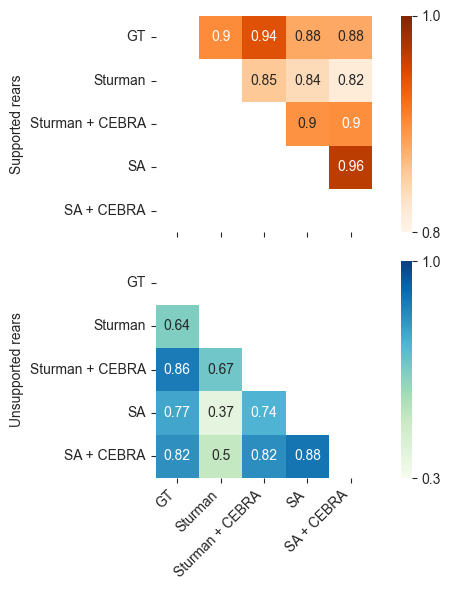

In [28]:
def plot_figure3f():
    cmap = 'GnBu'
    table = pd.read_csv('../data/Figure4/corrmat.csv', sep=';', header=[0, 1], index_col=0)
    fig, axes = plt.subplots(nrows=2, figsize=(6, 6))
    corr_sup = table.loc(axis=1)[['sup_gt', 'sup']].corr()
    inds = np.diag_indices(5)
    corr_sup.to_numpy()[inds] = np.nan
    triu = np.triu(corr_sup)
    corr_unsup = table.loc(axis=1)[['unsup_gt', 'unsup']].corr()
    tril = np.tril(corr_unsup)
    corr_unsup.to_numpy()[inds] = np.nan
    sns.heatmap(corr_sup, vmin=0.8, vmax=1, mask=tril, cmap='Oranges', annot=True, ax=axes[0], cbar_kws={'ticks': [.8, 1]})
    sns.heatmap(corr_unsup, vmin=0.3, vmax=1, mask=triu, cmap=cmap, annot=True, ax=axes[1], cbar_kws={'ticks': [0.3, 1]})
    axes[0].set_ylabel('Supported rears')
    axes[0].set_xticklabels('')
    axes[0].set_xlabel('')
    axes[0].set_aspect('equal')
    axes[1].set_ylabel('Unsupported rears')
    axes[1].set_aspect('equal')
    labels = ['GT', 'Sturman', 'Sturman + CEBRA', 'SA', 'SA + CEBRA']
    axes[1].set_xticklabels(
        labels,
        rotation=45,
        ha='right',
    )
    axes[1].set_yticklabels(labels)
    axes[0].set_yticklabels(labels)
    axes[1].set_xlabel('')
    fig.set_tight_layout(True)

plot_figure3f()

# Visualize horse fore and hindlimb stance periods

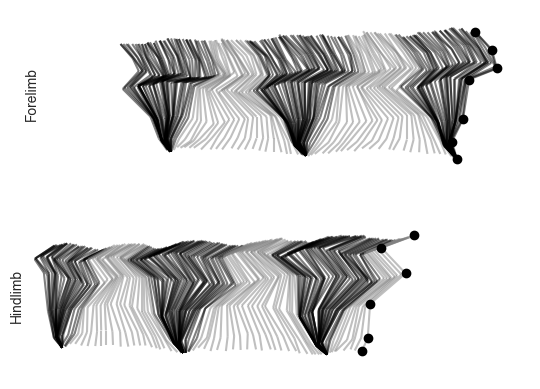

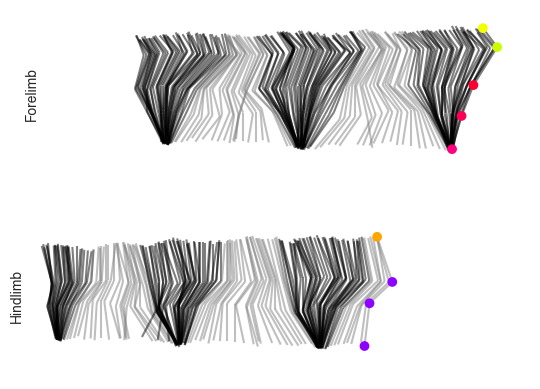

In [4]:
def load_json(json_file):
    with open(json_file) as f:
        data = json.load(f)
    coords = np.full((max(map(int, data)) + 1, len(keypoints), 3), np.nan)
    for ind, list_ in data.items():
        if not list_:
            continue
        coords[int(ind)] = np.array(list_[0]['keypoints'])
    mi = pd.MultiIndex.from_product([['Byron'], keypoints, ['x', 'y']], names=['scorer', 'bodyparts', 'coords'])
    df = pd.DataFrame(
        coords[..., :2].reshape((coords.shape[0], -1)),
        columns=mi
    )
    return df, coords

def get_events(df, event, hoof_kpt_names, ref_kpt_name, min_dist=50, detrend=True):
    keypoints = list(df.columns.get_level_values('bodyparts').unique())
    coords = df.copy().to_numpy().reshape((df.shape[0], -1, 2))
    # Center data
    if ref_kpt_name:
        temp = coords[:, keypoints.index(ref_kpt_name), :2]
        # Evaluate the animal's horizontal displacement when
        # the reference point is unseen.
        t = np.arange(coords.shape[0])
        mask = ~np.isnan(temp).any(axis=1)
        temp[:, 0] = np.poly1d(np.polyfit(np.flatnonzero(mask), temp[mask, 0], 1))(t)
        temp[:, 1] = np.poly1d(np.polyfit(np.flatnonzero(mask), temp[mask, 1], 1))(t)
        coords[..., :2] -= temp[:, None]
    events = []
    for pt in hoof_kpt_names:
        x = coords[:, keypoints.index(pt), 0]
        if event == 'lift':
            x = -x
        if detrend:
            signal.detrend(x[~np.isnan(x)], overwrite_data=True)
        events.append(signal.find_peaks(
            x,
            distance=min_dist,
        )[0])
    return events, coords

def get_stances(contacts, lifts):
    stances = []
    for contacts_, lifts_ in zip(contacts, lifts):
        temp = set()
        for c1, c2 in zip(contacts_[:-1], contacts_[1:]):  # Individual strides
            lift = lifts_[(lifts_ > c1) & (lifts_ < c2)]
            if not lift.size:
                continue
            temp.add((c1, lift[0]))
        for l1, l2 in zip(lifts_[:-1], lifts_[1:]):
            contact = contacts_[(contacts_ > l1) & (contacts_ < l2)]
            if not contact.size:
                continue
            temp.add((contact[0], l2))
        stances.append(list(temp))
    return stances

def _make_line_collection(coords, inds_stance, links, start=0, end=-1, color_stance='plum', alpha=0.5):
    mask_stance = np.zeros(coords.shape[0], dtype=bool)
    for inds in inds_stance:
        mask_stance[inds[0]:inds[1] + 1] = True
    color = mcolors.to_rgb('gray')
    colors = np.array([color] * len(coords))
    colors[mask_stance] = mcolors.to_rgb(color_stance)
    sl = slice(start, end)
    colors = colors[sl]
    segs = coords[sl, links].reshape((-1, 2, 2))
    colors = np.repeat(colors, len(links), axis=0)
    coll = LineCollection(segs, colors=colors, alpha=alpha)
    return coll, segs

with open('../data/Figure4/keypoints.yaml') as f:
    cfg = YAML().load(f)
    keypoints = list(cfg['all_joints_names'])

hooves_gt = 'Offfrontfoot', 'Offhindfoot'
ref_kpt_name_gt = 'Wither'
hooves = 'front_right_paw', 'back_right_paw'
ref_kpt_name = 'back_base'
front_limb_gt = [
    ('Offfrontfoot', 'Offfrontfetlock'),
    ('Offknee', 'Offfrontfetlock'),
    ('Offknee', 'Elbow'),
    ('Shoulder', 'Elbow'),
    ('Shoulder', 'Midshoulder'),
    ('Wither', 'Midshoulder'),
]
hind_limb_gt = [
    ('Offhindfoot', 'Offhindfetlock'),
    ('Offhindhock', 'Offhindfetlock'),
    ('Offhindhock', 'Stifle'),
    ('Ischium', 'Stifle'),
    ('Ischium', 'Hip'),
]
front_limb = [
    ('front_right_paw', 'front_right_knee'),
    ('front_right_thai', 'front_right_knee'),
    ('front_right_thai', 'neck_base'),
    ('back_base', 'neck_base'),
]
hind_limb = [
    ('back_right_paw', 'back_right_knee'),
    ('back_right_thai', 'back_right_knee'),
    ('back_right_thai', 'tail_base'),
]

# Load SA predictions and GT
df, coords = load_json('../data/Figure4/Brownhorseoutofshadow.mp4.json')
df_gt = pd.read_hdf('../data/Figure4/CollectedData_Byron.h5')
keypoints_gt = list(df_gt.columns.get_level_values('bodyparts').unique())
links_front_limb_gt = [tuple(keypoints_gt.index(pt) for pt in pts) for pts in front_limb_gt]
links_hind_limb_gt = [tuple(keypoints_gt.index(pt) for pt in pts) for pts in hind_limb_gt]
links_front_limb = [tuple(keypoints.index(pt) for pt in pts) for pts in front_limb]
links_hind_limb = [tuple(keypoints.index(pt) for pt in pts) for pts in hind_limb]

# Apply a zero-phase, low-pass Butterworth filter to smooth the data
cutoff = 3
b, a = signal.butter(2, cutoff, fs=24)
mask = df.isna()
df[mask] = 0
# df[:] = signal.filtfilt(b, a, df, axis=0)
df[mask] = np.nan
sl = slice(50, -50)  # Trim the start and end of the data, when the horse is not fully seen
df = df.iloc[sl]
coords = df.to_numpy().reshape((len(df), -1, 2))

mask = df_gt.isna()
df_gt[mask] = 0
# df_gt[:] = signal.filtfilt(b, a, df_gt, axis=0)
df_gt[mask] = np.nan
df_gt = df_gt.iloc[sl]
coords_gt = df_gt.to_numpy().reshape((df_gt.shape[0], -1, 2))

# Get hoof contacts and lifts
contacts, _ = get_events(df, 'contact', hooves, ref_kpt_name)
lifts, _ = get_events(df, 'lift', hooves, ref_kpt_name)
stances = get_stances(contacts, lifts)

contacts_gt, _ = get_events(df_gt, 'contact', hooves_gt, ref_kpt_name_gt)
lifts_gt, _ = get_events(df_gt, 'lift', hooves_gt, ref_kpt_name_gt)
stances_gt = get_stances(contacts_gt, lifts_gt)

s, e = 35, 35
coll_gt, segs_gt = _make_line_collection(coords_gt, stances_gt[0], links_front_limb_gt, start=s, end=-e, color_stance='k')
coll_gt2, segs_gt2 = _make_line_collection(coords_gt, stances_gt[1], links_hind_limb_gt, start=s, end=-e, color_stance='k')
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_aspect('equal')
xmin, ymin = np.nanmin(np.r_[segs_gt, segs_gt2], axis=(0, 1))
xmax, ymax = np.nanmax(np.r_[segs_gt, segs_gt2], axis=(0, 1))
axes[0].set_xlim(xmin, xmax + 10)
axes[0].set_ylim(ymin - 10, ymax + 10)
axes[0].invert_yaxis()
axes[0].add_collection(coll_gt)
axes[0].set_ylabel('Forelimb')
temp = coords_gt[s:-e, list(set(kpt for p in links_front_limb_gt for kpt in p))]
axes[0].scatter(*temp[-1].T, zorder=99, c='k')
axes[1].add_collection(coll_gt2)
axes[1].set_ylabel('Hindlimb')
temp = coords_gt[s:-e, list(set(kpt for p in links_hind_limb_gt for kpt in p))]
axes[1].scatter(*temp[-1].T, zorder=99, c='k')

coll, segs = _make_line_collection(coords, stances[0], links_front_limb, start=s, end=-e, color_stance='k')
coll2, segs2 = _make_line_collection(coords, stances[1], links_hind_limb, start=s, end=-e, color_stance='k')
fig, axes = plt.subplots(nrows=2, sharex=True, sharey=True)
for ax in axes:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_aspect('equal')
axes[0].set_xlim(xmin, xmax + 10)
axes[0].set_ylim(ymin - 10, ymax + 10)
axes[0].invert_yaxis()
axes[0].add_collection(coll)
forelimb_point_colors = {
    'back_base': '#F3FF00',
    'neck_base': '#CBFF00',
    'front_right_thai': '#FF0032',
    'front_right_knee': '#FF0059',
    'front_right_paw': '#FF0081',
}
inds_points = [keypoints.index(kpt) for kpt in forelimb_point_colors]
temp = coords[s:-e, inds_points]
axes[0].scatter(*temp[-1].T, c=list(forelimb_point_colors.values()), zorder=99)
axes[0].set_ylabel('Forelimb')
axes[1].add_collection(coll2)
axes[1].set_ylabel('Hindlimb')
hindlimb_point_colors = {
    'tail_base': '#FFA500',
    'back_right_thai': '#8E00FF',
    'back_right_knee': '#8E00FF',
    'back_right_paw': '#8E00FF',
}
inds_points = [keypoints.index(kpt) for kpt in hindlimb_point_colors]
temp = coords[s:-e, inds_points]
axes[1].scatter(*temp[-1].T, c=list(hindlimb_point_colors.values()), zorder=99)

# Contact count mismatch between GT and predictions

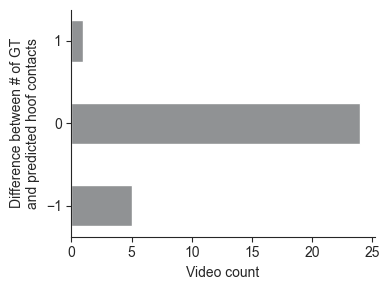

In [14]:
ncontacts = np.load('../data/Figure4/ncontacts.npy')
diff = np.diff(ncontacts, axis=1).squeeze()
fig, ax = plt.subplots(figsize=(4, 3), tight_layout=True)
bars = ax.hist(diff[:, 0], align='left', rwidth=0.5, color='#909294', bins=range(-1, 3), orientation='horizontal')
ax.set_yticks([-1, 0, 1])
ax.set_ylabel('Difference between # of GT\nand predicted hoof contacts')
ax.set_xlabel('Video count')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot agreement between GT and predicted stride lengths

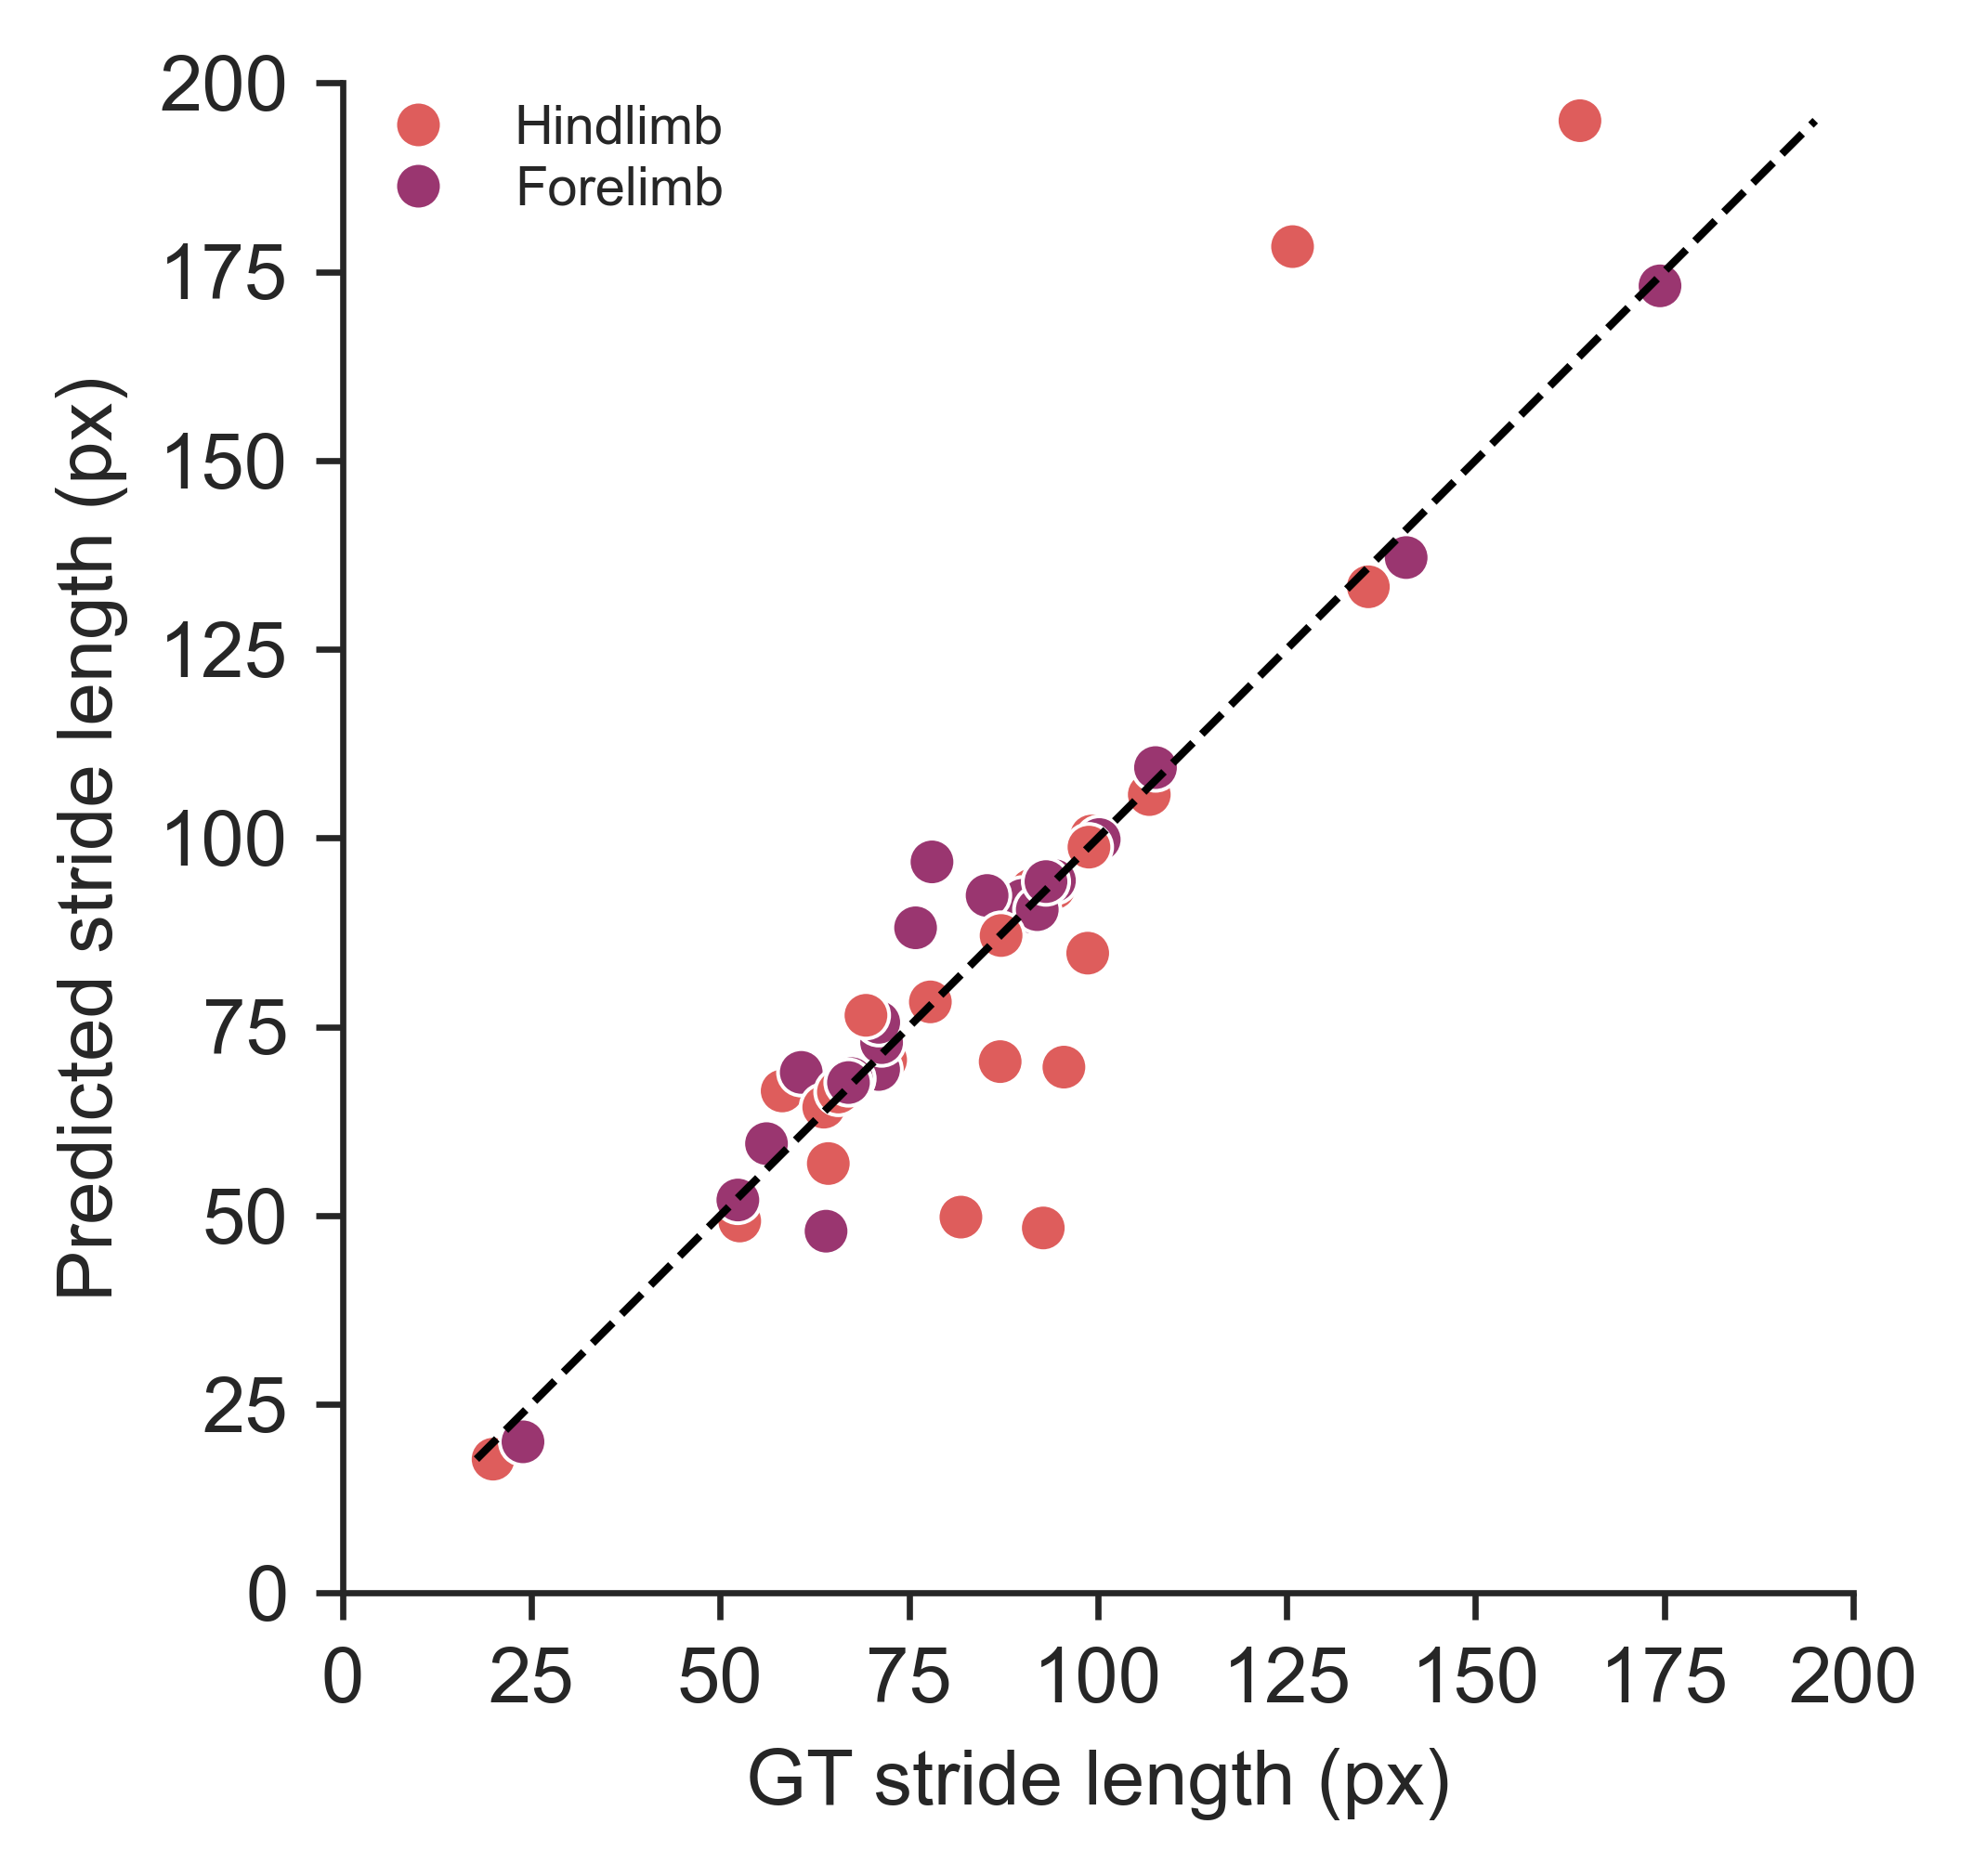

In [8]:
temp = pd.read_hdf('../data/Figure4/stridelengths.h5')
lim = 0, 200
g = sns.jointplot(
    x="gt", y="pred", data=temp,
    xlim=lim, ylim=lim,
    ratio=6, height=4,
    hue="level_1", palette='flare',
)
g.ax_marg_x.remove()
g.ax_marg_y.remove()
ax = g.fig.axes[0]
ax.set_aspect('equal')
min_ = temp.loc[:, ['gt', 'pred']].min().min()
max_ = temp.loc[:, ['gt', 'pred']].max().max()
line = np.linspace(min_, max_, 100)
g.fig.set_dpi(600)
g.fig.set_size_inches((4, 4))
ax.set_xlabel('GT stride length (px)')
ax.set_xticks(ax.get_yticks())
ax.set_ylabel('Predicted stride length (px)')
ax.set_xlim(*lim)
ax.set_ylim(*lim)
ax.plot(line, line, color='k', marker=None, ls='--', lw=1)
handles, labels = ax.get_legend_handles_labels()
labels[labels.index('back_right_paw')] = 'Hindlimb'
labels[labels.index('front_right_paw')] = 'Forelimb'
ax.legend(
    handles=handles,
    labels=labels,
    loc="best",
    frameon=False,
    borderaxespad=0.0,
    ncol=1,
    columnspacing=1,
    labelspacing=0.2,
    fontsize='x-small',
    scatteryoffsets=[0.5],
)